In [1]:
import sys
import os
import json

from shapely.geometry import Point
import rasterio
import fiona
import geopandas as gpd
from django.contrib.gis.geos.geometry import GEOSGeometry
from matplotlib import pyplot as plt
from pyproj import Proj
from rasterio.crs import CRS as CRS_rio
from rasterio.warp import transform_geom
from rasterio.features import rasterize
from affine import Affine
from shapely.geometry import shape
import dill

In [2]:
sys.__stdout__ = sys.stdout 

In [3]:
from datacube.api import GridWorkflow

from madmex.overlay.extractions import zonal_stats_xarray
from madmex.io.vector_db import VectorDb
from madmex.wrappers import gwf_query
from madmex.modeling.supervised.xgb import Model
from madmex.models import Tag
from madmex.overlay.extractions import zonal_stats_xarray
from madmex.util import randomword
from madmex.models import PredictObject

2020-07-16 17:02:41,202 - datacube.drivers.driver_cache - driver_cache safe_load: Failed to resolve driver datacube.plugins.index::s3aio_index
2020-07-16 17:02:41,204 - datacube.drivers.driver_cache - driver_cache safe_load: Error was: UndefinedEnvironmentName("'extra' does not exist in evaluation environment.",)


In [4]:
sys.stdout = sys.__stdout__

In [5]:
path = "/LUSTRE/MADMEX/tasks/2020/4_landcover_manglares_check/"

In [6]:
#Next product to fitc model
name_of_product = 'recipe_mex_s2_20m_2018_2019'
region = 'mexico_Quintana_Roo'
begin = '2018-01-01'
end = '2019-12-31'
#resolution = (-10,10)
#tilesize = (50020,50020)
#origin = (2426720, 977160)
#proj4 = '+proj=lcc +lat_1=17.5 +lat_2=29.5 +lat_0=12 +lon_0=-102 +x_0=2500000 +y_0=0 +a=6378137 +b=6378136.027241431 +units=m +no_defs'
#gwf_kwargs = {'region': region, 'product': name_of_product, 'begin': begin, 'end':end,
#              'resolution': resolution, 'origin': origin,
#              'proj4': proj4, 'tilesize': tilesize}
gwf_kwargs = {'region': region, 'product': name_of_product, 'begin': begin, 'end':end}
iterable = gwf_query(**gwf_kwargs)

In [7]:
lista_iter_20m = list(iterable)

In [8]:
lista_iter_20m_sorted = sorted(lista_iter_20m, key = lambda x: (x[0][0], x[0][1]))

In [9]:
tile = lista_iter_20m_sorted[15]

In [10]:
tile[0]

(59, -31)

In [11]:
sr_0 = GridWorkflow.load(tile[1])

In [12]:
sr_0

<xarray.Dataset>
Dimensions:     (time: 1, x: 2501, y: 2501)
Coordinates:
  * time        (time) datetime64[ns] 2018-12-31T12:00:00
  * y           (y) float64 9.261e+05 9.261e+05 ... 8.761e+05 8.761e+05
  * x           (x) float64 3.928e+06 3.928e+06 ... 3.978e+06 3.978e+06
Data variables:
    blue_mean   (time, y, x) int16 456 453 452 492 503 ... 653 570 589 555 566
    green_mean  (time, y, x) int16 606 622 634 681 703 ... 853 773 794 741 745
    red_mean    (time, y, x) int16 431 452 464 510 514 ... 612 542 573 520 512
    re1_mean    (time, y, x) int16 904 950 970 1019 1035 ... 1135 1172 1114 1116
    re2_mean    (time, y, x) int16 2168 2267 2309 2402 ... 2726 2734 2675 2693
    re3_mean    (time, y, x) int16 2685 2816 2844 2926 ... 3354 3348 3293 3301
    nir_mean    (time, y, x) int16 3000 3137 3152 3235 ... 3716 3720 3663 3672
    swir1_mean  (time, y, x) int16 1604 1656 1657 1697 ... 1807 1867 1844 1852
    swir2_mean  (time, y, x) int16 798 840 837 868 887 ... 914 894 956 923 923
    ndvi_mean   (time, y, x) int16 7628 7667 7670 7612 ... 7630 7576 7673 7646
    ndmi_mean   (time, y, x) int16 3095 3199 3211 3224 ... 3496 3389 3358 3338
    ndvi_max    (time, y, x) int16 9047 8985 8999 9030 ... 9475 9419 9488 9415
    ndvi_min    (time, y, x) int16 2028 2134 2187 2046 ... 2343 2494 2631 2728
    ndmi_max    (time, y, x) int16 4719 4647 4677 4744 ... 4593 4457 4392 4439
    ndmi_min    (time, y, x) int16 1731 2055 1602 1343 ... 1134 1056 755 638
    elevation   (time, y, x) int16 29 29 29 29 29 28 28 ... 13 13 13 13 12 12 12
    slope       (time, y, x) float32 0.58900684 0.58900684 ... 0.43751022
    aspect      (time, y, x) float32 23.198593 23.198593 ... 315.0 315.0
Attributes:
    crs:      PROJCS["unnamed",GEOGCS["WGS 84",DATUM["unknown",SPHEROID["WGS8...

In [13]:
training_data = "quintana_roo_s2_2018_madmex_17_clases"
training_data = "points_quintana_roo_s2_2018_madmex_17_classes"

In [14]:
loader = VectorDb()
fc_train_0 = loader.load_training_from_dataset(dataset=sr_0,
                                               training_set=training_data, sample=1)


In [15]:
# Evaluate the generator (safe to do here since the data is relatively small)
fc_train_0 = list(fc_train_0)

In [16]:
len(fc_train_0)

9787

In [17]:
scheme = "madmex_17"

In [18]:
qs = Tag.objects.filter(scheme=scheme)
tag_mapping = {x.id:x.numeric_code for x in qs}
tag_id_list = [x['properties']['class'] for x in fc_train_0]


In [19]:
fc_train = [{'geometry': x[0]['geometry'],
             'properties': {'code': tag_mapping[x[1]]},
             'type': 'feature'} for x in zip(fc_train_0, tag_id_list)]

In [20]:
fc_train[0]

{'geometry': {'type': 'Point',
  'coordinates': [3930908.014362283, 872235.9249802266]},
 'properties': {'code': 5},
 'type': 'feature'}

In [21]:
gdf_from_features = gpd.GeoDataFrame.from_features(fc_train)

In [22]:
gdf_from_features.head()

,geometry,code
0,POINT (3930908.014 872235.925),5
1,POINT (3930908.416 871521.346),5
2,POINT (3937309.463 872232.247),5
3,POINT (3937736.227 872232.002),5
4,POINT (3938162.990 872231.756),5


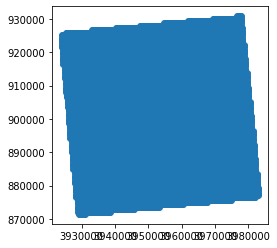

In [23]:
gdf_from_features.plot()
plt.show()

In [24]:
len(gdf_from_features['code'].unique())

10

In [125]:
gdf_from_features.total_bounds

array([3924050.26270804,  871521.34648215, 3982970.35478215,
        930803.01573357])

In [25]:
crs_dict = {'proj': 'lcc',
            'lat_1': 17.5,
            'lat_2': 29.5,
            'lat_0': 12,
            'lon_0': -102,
            'x_0': 2500000,
            'y_0': 0,
            'datum': 'WGS84',
            'units': 'm',
            'no_defs': True,
            'a':6378137,
            'b':6378136.027241431,
            'wktext': True}

In [26]:
gdf_from_features.crs

In [27]:
gdf_from_features.crs = crs_dict

In [28]:
path

'/LUSTRE/MADMEX/tasks/2020/4_landcover_manglares_check/'

In [29]:
#fc_train_filename = path + 'train_fc_quintana_roo_s2_2018_madmex_17_clases' + '_%d_%d' %(tile[0][0],tile[0][1]) + '.shp'

In [30]:
#fc_train_filename

In [31]:
#gdf_from_features.to_file(fc_train_filename)

In [32]:
#for feature in fc_train:
#    feature['geometry'] = transform_geom(CRS_rio.from_dict(crs_dict),
#                                         CRS_rio.from_epsg(4326),
#                                         feature['geometry'])

In [33]:
#fc_train[0]

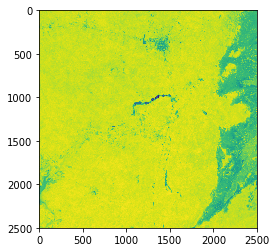

In [34]:
plt.imshow(sr_0.ndvi_mean[0,:,:])
plt.show()

In [35]:
#from madmex.overlay.conversions import rasterize_xarray

In [36]:
#arr = rasterize_xarray(fc_train, sr_0)

In [37]:
#arr

In [38]:
#import numpy as np

In [39]:
#np.all(np.isnan(arr))

In [40]:
#geom_list = [x['geometry'] for x in fc_train]

In [41]:
#iterable = zip(geom_list, range(1, len(geom_list) + 1))

In [42]:
#aff = Affine(*list(sr_0.affine)[0:6])

In [43]:
#dimensions_dataset = list(sr_0.coords)

In [44]:
#list_dimensions = [x for x in dimensions_dataset if x != 'time']

In [45]:
#list_dimensions

In [46]:
#lambda_function = lambda l_netcdf,l_test: l_netcdf[0] if l_netcdf[0] in l_test else l_netcdf[1]
#xdim = lambda_function(list_dimensions,['x','longitude'])
#ydim = lambda_function(list_dimensions,['y','latitude'])
#

In [47]:
#fc_raster = rasterize(iterable, transform=aff,
#                      out_shape=(sr_0.sizes[ydim], sr_0.sizes[xdim]),
#                      dtype='float64', fill=np.nan)

In [48]:
#sr_0.sizes[xdim]

In [49]:
#fc_raster

In [50]:
X_train, y_train = zonal_stats_xarray(sr_0, fc_train, 'code')

In [51]:
X_train

array([[4.48000000e+02, 6.34000000e+02, 4.22000000e+02, ...,
        1.80000000e+01, 1.97109234e+00, 3.11820190e+02],
       [3.59000000e+02, 5.47000000e+02, 3.24000000e+02, ...,
        1.90000000e+01, 1.07713807e+00, 6.89624863e+01],
       [4.71000000e+02, 6.97000000e+02, 4.87000000e+02, ...,
        1.60000000e+01, 2.44431996e+00, 1.08434952e+02],
       ...,
       [6.91000000e+02, 9.15000000e+02, 8.59000000e+02, ...,
        2.00000000e+00, 5.89006841e-01, 2.31985931e+01],
       [5.20000000e+02, 6.64000000e+02, 4.93000000e+02, ...,
        1.50000000e+01, 2.12279749e+00, 3.31113434e+01],
       [6.86000000e+02, 8.97000000e+02, 7.03000000e+02, ...,
        3.00000000e+00, 2.10301518e+00, 1.62897278e+02]])

In [52]:
X_train.shape

(8203, 18)

In [53]:
y_train

array([5, 5, 5, ..., 4, 4, 4])

In [54]:
xgb_model = Model()

In [55]:
xgb_model.fit(X_train, y_train)

In [56]:
#from xgboost.sklearn import XGBClassifier

In [57]:
#n_estimators=50
#n_jobs=-1
#max_depth=10
#learning_rate=0.1
#gamma=0
#reg_alpha=0
#reg_lambda=1
#random_state=0

In [58]:
#xgb_model_sklearn = XGBClassifier(objective='multi:softmax', n_estimators=n_estimators,
#                                  n_jobs=n_jobs, max_depth=max_depth,
#                                  learning_rate=learning_rate, gamma=gamma,
#                                  reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state)

In [59]:
#xgb_model_sklearn

In [60]:
#save model

In [61]:
path 

'/LUSTRE/MADMEX/tasks/2020/4_landcover_manglares_check/'

In [62]:
name_model = 'model_quintana_roo_s2_2018_madmex_17_clases' + '_%d_%d' %(tile[0][0],tile[0][1])
filename_model = '%s_%s.pkl' % (name_model, randomword(5))
filepath_model = os.path.join(path, filename_model)

In [63]:
filepath_model

'/LUSTRE/MADMEX/tasks/2020/4_landcover_manglares_check/model_quintana_roo_s2_2018_madmex_17_clases_59_-31_bwiwb.pkl'

In [64]:
with open(filepath_model, 'wb') as dst:
    dill.dump(xgb_model, dst)

In [ ]:
#load segmentation

In [65]:
seg_name = 'seg_mex_s2_10m_scl_2018_2019'

In [66]:
geom = GEOSGeometry(json.dumps(sr_0.geobox.geographic_extent.json))
qs = PredictObject.objects.filter(the_geom__contained=geom,segmentation_information__name=seg_name)
path_seg = qs[0].path

In [67]:
path_seg

'/shared_volume/segmentation_antares3_results/bis_seg_mex_s2_10m_scl_2018_2019_sentinel_2_59_-31_2018_2019.shp'

In [119]:
with fiona.open(path_seg) as src:
    X_pred, _ = zonal_stats_xarray(sr_0, src, 'id')
    y_pred = xgb_model.predict(X_pred)
    fc_pred = [(x[0]['geometry'], x[1]) for x in zip(src, y_pred)]
    source_driver = src.driver
    source_crs = src.crs
    source_schema = src.schema

In [120]:
X_pred

array([[6.00333333e+02, 7.80333333e+02, 5.86666667e+02, ...,
        3.10000000e+01, 5.46881795e-01, 2.78130096e+02],
       [4.61166667e+02, 6.35666667e+02, 4.27916667e+02, ...,
        2.90833333e+01, 5.70537746e-01, 5.91174393e+01],
       [4.03800000e+02, 5.90600000e+02, 4.09500000e+02, ...,
        2.86000000e+01, 3.58088136e-01, 3.23421753e+02],
       ...,
       [6.56028571e+02, 8.07714286e+02, 6.06000000e+02, ...,
        1.35142857e+01, 4.12049651e-01, 1.58427429e+02],
       [5.81161765e+02, 7.37632353e+02, 5.31485294e+02, ...,
        1.43382353e+01, 4.03057367e-01, 1.28059402e+02],
       [6.29114286e+02, 8.22214286e+02, 5.96185714e+02, ...,
        1.35571429e+01, 4.44343418e-01, 1.98929031e+02]])

In [121]:
y_pred

array([5, 5, 5, ..., 5, 5, 5])

In [122]:
import numpy as np

In [123]:
np.unique(y_pred)

array([ 4,  5,  6, 10, 13, 14, 15, 16, 17])

In [124]:
fc_pred[0]

({'type': 'Polygon',
  'coordinates': [[(3928510.0, 926120.0),
    (3928580.0, 926120.0),
    (3928580.0, 926100.0),
    (3928590.0, 926100.0),
    (3928590.0, 926090.0),
    (3928580.0, 926090.0),
    (3928560.0, 926090.0),
    (3928560.0, 926080.0),
    (3928550.0, 926080.0),
    (3928550.0, 926070.0),
    (3928540.0, 926070.0),
    (3928540.0, 926100.0),
    (3928530.0, 926100.0),
    (3928530.0, 926110.0),
    (3928520.0, 926110.0),
    (3928520.0, 926100.0),
    (3928510.0, 926100.0),
    (3928510.0, 926120.0)]]},
 5)

In [126]:
fc_schema = {'geometry': 'Polygon',
         'properties': {'code': 'int'}}
fc_pred_geojson = [{'geometry': x[0],
                  'properties': {'code': int(x[1])}, #why is necessary to transform to int ???
                  'type': 'feature'} for x in fc_pred]

In [127]:
fc_pred_geojson[0]

{'geometry': {'type': 'Polygon',
  'coordinates': [[(3928510.0, 926120.0),
    (3928580.0, 926120.0),
    (3928580.0, 926100.0),
    (3928590.0, 926100.0),
    (3928590.0, 926090.0),
    (3928580.0, 926090.0),
    (3928560.0, 926090.0),
    (3928560.0, 926080.0),
    (3928550.0, 926080.0),
    (3928550.0, 926070.0),
    (3928540.0, 926070.0),
    (3928540.0, 926100.0),
    (3928530.0, 926100.0),
    (3928530.0, 926110.0),
    (3928520.0, 926110.0),
    (3928520.0, 926100.0),
    (3928510.0, 926100.0),
    (3928510.0, 926120.0)]]},
 'properties': {'code': 5},
 'type': 'feature'}

In [146]:
#gdf_pred = gpd.GeoDataFrame.from_features([feature for feature in fc_pred_geojson], 
#                                          crs = crs_dict)

In [149]:
#gdf_pred.head()

In [164]:
#bbox = gdf_pred.total_bounds

In [165]:
#bbox

In [166]:
#p1 = Point(bbox[0], bbox[3])
#p2 = Point(bbox[2], bbox[3])
#p3 = Point(bbox[2], bbox[1])
#p4 = Point(bbox[0], bbox[1])

In [167]:
#x_min, x_max = p1.coords.xy[0][0], p3.coords.xy[0][0]
#y_min, y_max = p3.coords.xy[1][0], p1.coords.xy[1][0]

In [168]:
#x_min, x_max

In [169]:
#y_min, y_max

In [170]:
#nrows = int(((y_max - y_min) // resolution) + 1)
#ncols = int(((x_max - x_min) // resolution) + 1)
#shape_dim = (nrows, ncols)

In [137]:
shape_dim

(4910, 5003)

In [148]:
gdf_seg = gpd.read_file(path_seg)

In [187]:
gdf_seg.head()

,id,geometry
0,305601,"POLYGON ((3928510.000 926120.000, 3928580.000 ..."
1,305602,"POLYGON ((3928670.000 926120.000, 3928800.000 ..."
2,305643,"POLYGON ((3929530.000 926120.000, 3929670.000 ..."
3,305645,"POLYGON ((3930760.000 926120.000, 3930780.000 ..."
4,305646,"POLYGON ((3931360.000 926120.000, 3931480.000 ..."


In [188]:
bbox = gdf_seg.total_bounds

In [189]:
bbox

array([3928340.,  876100., 3978360.,  926120.])

In [190]:
p1 = Point(bbox[0], bbox[3])
p2 = Point(bbox[2], bbox[3])
p3 = Point(bbox[2], bbox[1])
p4 = Point(bbox[0], bbox[1])

In [191]:
x_min, x_max = p1.coords.xy[0][0], p3.coords.xy[0][0]
y_min, y_max = p3.coords.xy[1][0], p1.coords.xy[1][0]

In [192]:
x_min, x_max

(3928340.0, 3978360.0)

In [193]:
y_min, y_max

(876100.0, 926120.0)

In [194]:
nrows = int(((y_max - y_min) // resolution) + 1)
ncols = int(((x_max - x_min) // resolution) + 1)
shape_dim = (nrows, ncols)

In [195]:
shape_dim

(5003, 5003)

In [204]:
gdf_seg.crs

{'proj': 'lcc',
 'lat_1': 17.5,
 'lat_2': 29.5,
 'lat_0': 12,
 'lon_0': -102,
 'x_0': 2500000,
 'y_0': 0,
 'a': 6378137,
 'b': 6378136.027241431,
 'units': 'm',
 'no_defs': True}

**Using segmentation query**

In [205]:
#poly = geom
#poly_geojson = poly.geojson
#geometry_seg = json.loads(poly_geojson)

In [186]:
#shape(geometry_seg).bounds

(-88.35405594408851, 19.1825423641335, -87.83216732073984, 19.674709991847795)

In [206]:
#geometry_seg_proj = transform_geom(CRS_rio.from_epsg(4326),
#                                   CRS_rio.from_dict(crs_dict),
#                                   geometry_seg)

In [156]:
#geometry_seg_proj

{'type': 'Polygon',
 'coordinates': [[(3928908.9259553663, 921033.1939322166),
   (3928880.8876941726, 871289.1016682589),
   (3978916.9954529526, 871318.0564005955),
   (3978946.0123449345, 921062.086560307),
   (3928908.9259553663, 921033.1939322166)]]}

In [207]:
#xmin, ymin, xmax, ymax = shape(geometry_seg_proj).bounds

In [208]:
#nrows = int(((ymax - ymin) // resolution) + 1)
#ncols = int(((xmax - xmin) // resolution) + 1)
#shape_dim = (nrows, ncols)

In [209]:
shape_dim

(4978, 5007)

In [161]:
proj_crs = Proj(crs_dict)

In [162]:
proj_crs

Proj('+proj=lcc +lat_0=12 +lon_0=-102 +lat_1=17.5 +lat_2=29.5 +x_0=2500000 +y_0=0 +a=6378137 +b=6378136.02724143 +units=m +no_defs', preserve_units=True)

In [139]:
#bbox = np.array([3924050.26270804,  871521.34648215, 3982970.35478215,
#              930803.01573357])

In [171]:
#p1 = Point(bbox[0], bbox[3])
#p2 = Point(bbox[2], bbox[3])
#p3 = Point(bbox[2], bbox[1])
#p4 = Point(bbox[0], bbox[1])

In [172]:
#x_min, x_max = p1.coords.xy[0][0], p3.coords.xy[0][0]
#y_min, y_max = p3.coords.xy[1][0], p1.coords.xy[1][0]

In [173]:
#x_min, x_max

In [174]:
#y_min, y_max

In [175]:
#nrows = int(((y_max - y_min) // resolution) + 1)
#ncols = int(((x_max - x_min) // resolution) + 1)
#shape_dim = (nrows, ncols)

In [145]:
shape_dim

(5929, 5893)

In [196]:
filename_raster = path + 'raster_quintana_roo_s2_2018_madmex_17_clases' + '_%d_%d' %(tile[0][0],tile[0][1]) + '_3.tif'

In [197]:
filename_raster

'/LUSTRE/MADMEX/tasks/2020/4_landcover_manglares_check/raster_quintana_roo_s2_2018_madmex_17_clases_59_-31_3.tif'

In [198]:
resolution = 10

In [199]:

arr = np.zeros((nrows, ncols), dtype=np.uint8)
aff = Affine(resolution, 0, x_min, 0, -resolution, y_max)



In [200]:
shape_dim

(5003, 5003)

In [201]:
rasterize(shapes=fc_pred, transform=aff, dtype=np.uint8, out=arr)


array([[5, 5, 5, ..., 5, 5, 0],
       [5, 5, 5, ..., 5, 5, 0],
       [5, 5, 5, ..., 5, 5, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [202]:
meta = {'driver': 'GTiff',
        'width': shape_dim[1],
        'height': shape_dim[0],
        'count': 1,
        'dtype': arr.dtype,
        'crs': crs_dict,
        'transform': aff,
        'compress': 'lzw',
        'nodata': 0}

In [203]:
with rasterio.open(filename_raster, 'w', **meta) as dst:
    dst.write(arr, 1)

**next is dummy cell:**

In [ ]:
#rasterize
proj_crs = Proj(source_crs)
if not proj_crs.crs.is_geographic:
    geometry_seg_proj = transform_geom(CRS_rio.from_epsg(4326),
                                       CRS_rio.from_proj4(crs),
                                       geometry_seg)

# Just a few executions:

In [48]:
path_training_data = "/LUSTRE/MADMEX/products/landcover/sentinel2/2018/estados/Quintana_Roo/17_31_gpkg/Quintana_Roo_sentinel2_2018.gpkg"

In [49]:
import geopandas as gpd

In [50]:
gdf = gpd.read_file(path_training_data)

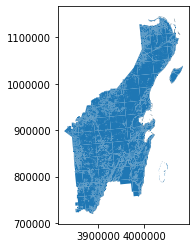

In [51]:
gdf.plot()
plt.show()

**Debugging zonal stats xarray for prediction**

In [210]:
path_seg

'/shared_volume/segmentation_antares3_results/bis_seg_mex_s2_10m_scl_2018_2019_sentinel_2_59_-31_2018_2019.shp'

In [211]:
var_list = list(sr_0.data_vars)

In [212]:
aggregation = 'mean'

In [213]:
agg_list = [(k, aggregation) for k in var_list]

In [214]:
agg_list

[('blue_mean', 'mean'),
 ('green_mean', 'mean'),
 ('red_mean', 'mean'),
 ('re1_mean', 'mean'),
 ('re2_mean', 'mean'),
 ('re3_mean', 'mean'),
 ('nir_mean', 'mean'),
 ('swir1_mean', 'mean'),
 ('swir2_mean', 'mean'),
 ('ndvi_mean', 'mean'),
 ('ndmi_mean', 'mean'),
 ('ndvi_max', 'mean'),
 ('ndvi_min', 'mean'),
 ('ndmi_max', 'mean'),
 ('ndmi_min', 'mean'),
 ('elevation', 'mean'),
 ('slope', 'mean'),
 ('aspect', 'mean')]

In [215]:
from collections import OrderedDict

In [216]:
agg_ordered_dict = OrderedDict(agg_list)

In [217]:
agg_ordered_dict

OrderedDict([('blue_mean', 'mean'),
             ('green_mean', 'mean'),
             ('red_mean', 'mean'),
             ('re1_mean', 'mean'),
             ('re2_mean', 'mean'),
             ('re3_mean', 'mean'),
             ('nir_mean', 'mean'),
             ('swir1_mean', 'mean'),
             ('swir2_mean', 'mean'),
             ('ndvi_mean', 'mean'),
             ('ndmi_mean', 'mean'),
             ('ndvi_max', 'mean'),
             ('ndvi_min', 'mean'),
             ('ndmi_max', 'mean'),
             ('ndmi_min', 'mean'),
             ('elevation', 'mean'),
             ('slope', 'mean'),
             ('aspect', 'mean')])

In [218]:
X_list = []
y_list = []

In [219]:
with fiona.open(path_seg) as src:
    fc_pred=[(x['properties']['id'], x['geometry']) for x in src]
    fc_pred_sorted = sorted(fc_pred, key=lambda x: x[0])

In [220]:
fc_pred_sorted[0]

(0,
 {'type': 'Polygon',
  'coordinates': [[(3928350.0, 876230.0),
    (3928380.0, 876230.0),
    (3928380.0, 876210.0),
    (3928370.0, 876210.0),
    (3928360.0, 876210.0),
    (3928360.0, 876160.0),
    (3928370.0, 876160.0),
    (3928370.0, 876100.0),
    (3928340.0, 876100.0),
    (3928340.0, 876220.0),
    (3928350.0, 876220.0),
    (3928350.0, 876230.0)]]})

In [221]:
y_list = [x[0] for x in fc_pred_sorted]

In [222]:
y_list[0]

0

In [223]:
len(y_list)

305721

In [225]:
y_list[len(y_list)-1]

305720

In [226]:
aff = Affine(*list(sr_0.affine)[0:6])

In [227]:
dimensions_dataset = list(sr_0.coords)

In [228]:
list_dimensions = [x for x in dimensions_dataset if x != 'time']
lambda_function = lambda l_netcdf,l_test: l_netcdf[0] if l_netcdf[0] in l_test else l_netcdf[1]
xdim = lambda_function(list_dimensions,['x','longitude'])
ydim = lambda_function(list_dimensions,['y','latitude'])

In [229]:
xdim

'x'

In [230]:
ydim

'y'

In [267]:
aff

Affine(20.0, 0.0, 3928340.0,
       0.0, -20.0, 926120.0)

In [233]:
geom_list = [x[1] for x in fc_pred_sorted]
# Prepare iterable to be passed to rasterio rasterize
iterable = zip(geom_list, range(1, len(geom_list) + 1))

In [234]:
fc_raster = rasterize(iterable, transform=aff,
                      out_shape=(sr_0.sizes[ydim], sr_0.sizes[xdim]),
                      dtype='float64', fill=np.nan)

In [266]:
sr_0.sizes

Frozen(SortedKeysDict({'time': 1, 'y': 2501, 'x': 2501}))

In [265]:
fc_raster.shape

(2501, 2501)

In [236]:
import xarray as xr

In [237]:
# Convert arr to a dataArray
xr_arr = xr.DataArray(fc_raster, dims=[ydim, xdim], name='features_id')


In [238]:
xr_arr

<xarray.DataArray 'features_id' (y: 2501, x: 2501)>
array([[3.02826e+05, 3.02826e+05, 3.02826e+05, ..., 3.05421e+05,
        3.05421e+05, 3.05515e+05],
       [3.02826e+05, 3.02826e+05, 3.02826e+05, ..., 3.05515e+05,
        3.05421e+05, 3.05515e+05],
       [3.02826e+05, 3.02826e+05, 3.05422e+05, ..., 3.05515e+05,
        3.05515e+05, 3.05515e+05],
       ...,
       [1.00000e+00, 1.00000e+00, 2.00000e+00, ..., 6.32000e+02,
        6.32000e+02, 6.32000e+02],
       [1.00000e+00, 1.00000e+00, 2.00000e+00, ..., 5.35000e+02,
        5.35000e+02, 6.32000e+02],
       [1.00000e+00, 1.00000e+00, 2.00000e+00, ..., 5.35000e+02,
        5.35000e+02, 5.35000e+02]])
Dimensions without coordinates: y, x

In [239]:
# Combine the Dataset with the DataArray
combined = xr.merge([xr_arr, sr_0])
# Get rid of everything that is np.nan in features_id variable
# 1: flatten, 2: delete nans
combined = combined.stack(z=(xdim, ydim)).reset_index('z').drop([xdim, ydim])
combined = combined.where(np.isfinite(combined['features_id']), drop=True)


In [240]:
# Coerce to pandas dataframe
df = combined.to_dataframe()
combined = None
df = df.groupby('features_id').agg(agg_ordered_dict)


In [241]:
df.head()

,blue_mean,green_mean,red_mean,re1_mean,re2_mean,re3_mean,nir_mean,swir1_mean,swir2_mean,ndvi_mean,ndmi_mean,ndvi_max,ndvi_min,ndmi_max,ndmi_min,elevation,slope,aspect
features_id,,,,,,,,,,,,,,,,,,
1.0,531.100000,734.200000,529.700000,1075.300000,2441.300000,2903.900000,3221.800000,1738.500000,888.600000,7480.300000,3132.600000,8837.000000,3192.300000,4548.400000,1187.700000,19.200000,1.577946,327.969574
2.0,482.076923,675.692308,458.423077,989.884615,2381.807692,2875.884615,3191.846154,1635.269231,808.807692,7708.538462,3352.692308,8974.000000,3419.076923,4793.384615,1314.846154,20.615385,1.882396,155.018005
3.0,571.312500,752.395833,565.458333,1076.687500,2312.708333,2752.145833,3047.208333,1719.395833,936.270833,7246.500000,2936.229167,8821.520833,2876.770833,4408.250000,1076.875000,18.625000,2.068401,22.304743
4.0,547.666667,705.000000,476.000000,975.000000,2329.333333,2843.333333,3145.333333,1589.000000,798.333333,7574.666667,3390.333333,9103.666667,3138.333333,4802.333333,1088.333333,20.666667,2.389013,20.046144
5.0,519.500000,694.375000,482.375000,984.000000,2267.375000,2708.250000,3007.500000,1609.000000,795.625000,7417.000000,3127.000000,8906.500000,2973.500000,4655.750000,963.875000,21.125000,2.677371,22.563782


In [245]:
X_pred = df.values

In [263]:
X_pred.shape

(300430, 18)

In [246]:
y_pred = xgb_model.predict(X_pred)

In [247]:
y_pred

array([5, 5, 5, ..., 5, 5, 5])

In [264]:
len(y_pred)

300430

In [248]:
poly = geom
poly_geojson = poly.geojson
geometry_seg = json.loads(poly_geojson)

In [250]:
xmin, ymin, xmax, ymax  = shape(geometry_seg).bounds

In [251]:
nrows = int(((ymax - ymin) // resolution) + 1)
ncols = int(((xmax - xmin) // resolution) + 1)
shape_dim = (nrows, ncols)

In [252]:
shape_dim

(1, 1)

In [253]:
gdf_seg = gpd.read_file(path_seg)

In [254]:
gdf_seg.head()

,id,geometry
0,305601,"POLYGON ((3928510.000 926120.000, 3928580.000 ..."
1,305602,"POLYGON ((3928670.000 926120.000, 3928800.000 ..."
2,305643,"POLYGON ((3929530.000 926120.000, 3929670.000 ..."
3,305645,"POLYGON ((3930760.000 926120.000, 3930780.000 ..."
4,305646,"POLYGON ((3931360.000 926120.000, 3931480.000 ..."


In [255]:
bbox = gdf_seg.total_bounds

In [256]:
bbox

array([3928340.,  876100., 3978360.,  926120.])

In [257]:
p1 = Point(bbox[0], bbox[3])
p2 = Point(bbox[2], bbox[3])
p3 = Point(bbox[2], bbox[1])
p4 = Point(bbox[0], bbox[1])

In [258]:
x_min, x_max = p1.coords.xy[0][0], p3.coords.xy[0][0]
y_min, y_max = p3.coords.xy[1][0], p1.coords.xy[1][0]

In [259]:
x_min, x_max

(3928340.0, 3978360.0)

In [260]:
y_min, y_max

(876100.0, 926120.0)

In [261]:
nrows = int(((y_max - y_min) // resolution) + 1)
ncols = int(((x_max - x_min) // resolution) + 1)
shape_dim = (nrows, ncols)

In [262]:
shape_dim

(5003, 5003)

In [ ]:
with fiona.open(path_seg) as src:
    X_pred, _ = zonal_stats_xarray(sr_0, src, 'id')
    y_pred = xgb_model.predict(X_pred)
    fc_pred = [(x[0]['geometry'], x[1]) for x in zip(src, y_pred)]
    source_driver = src.driver
    source_crs = src.crs
    source_schema = src.schema